In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from src.config import DADOS_ORIGINAIS, DADOS_TRATADOS
from src.helpers import analisar_cardinalidade, cramers_v

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(palette='bright')

In [2]:
# Importação da base de dados
df = pd.read_csv(DADOS_ORIGINAIS).rename(columns={'poisonous': 'class'})
df.head(3)

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e


In [3]:
# Colunas com valores nulos
for col in df.columns:
    nulls = df[col].isnull().sum()
    proportion = df[col].isnull().mean() * 100
    if nulls:
        print(f"{col}: {nulls} nulls ({proportion:.2f}%)")

stalk-root: 2480 nulls (30.53%)


In [4]:
# Tipos de dados das colunas
df.dtypes

cap-shape                   object
cap-surface                 object
cap-color                   object
bruises                     object
odor                        object
gill-attachment             object
gill-spacing                object
gill-size                   object
gill-color                  object
stalk-shape                 object
stalk-root                  object
stalk-surface-above-ring    object
stalk-surface-below-ring    object
stalk-color-above-ring      object
stalk-color-below-ring      object
veil-type                   object
veil-color                  object
ring-number                 object
ring-type                   object
spore-print-color           object
population                  object
habitat                     object
class                       object
dtype: object

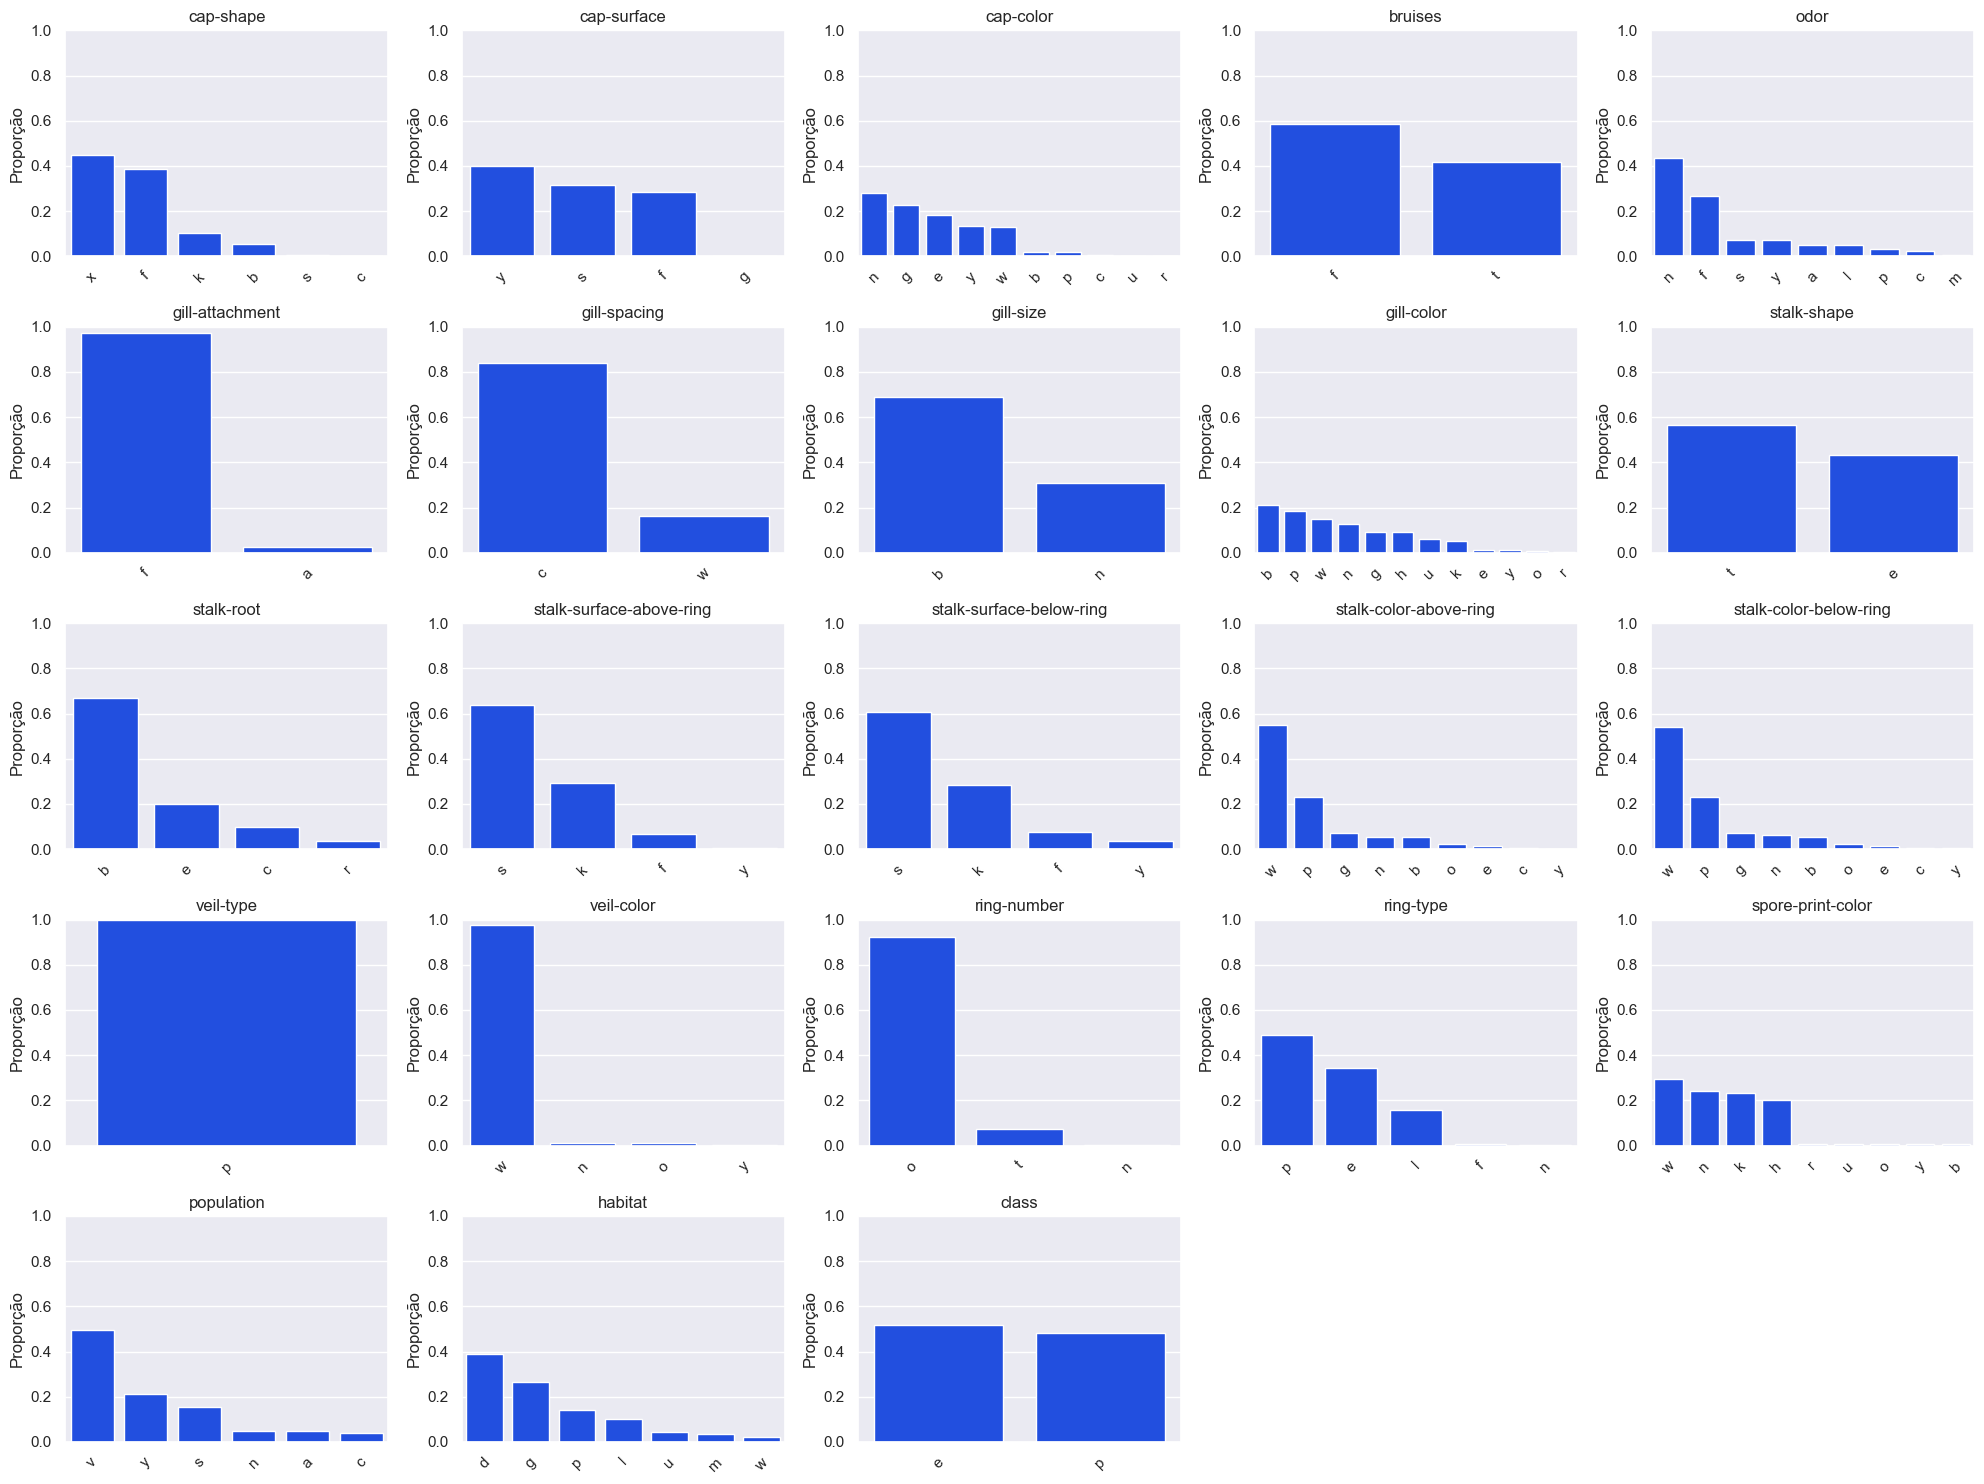

In [5]:
# Visualização do balanceamento entre valores das colunas
n_cols = 5
n_rows = (len(df.columns) // n_cols) + (1 if len(df.columns) % n_cols != 0 else 0)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    proporcoes = df[col].value_counts(normalize=True)
    sns.barplot(x=proporcoes.index, y=proporcoes.values, ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Proporção')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Análise de cardinalidade das colunas
df_cardinalidade = analisar_cardinalidade(df)
display(df_cardinalidade)

,feature,n_categorias,valor_mais_frequente_%
0,gill-color,12,21.27
1,cap-color,10,28.11
2,odor,9,43.43
3,spore-print-color,9,29.39
4,stalk-color-above-ring,9,54.95
5,stalk-color-below-ring,9,53.96
6,habitat,7,38.75
7,cap-shape,6,45.00
8,population,6,49.73
9,ring-type,5,48.84


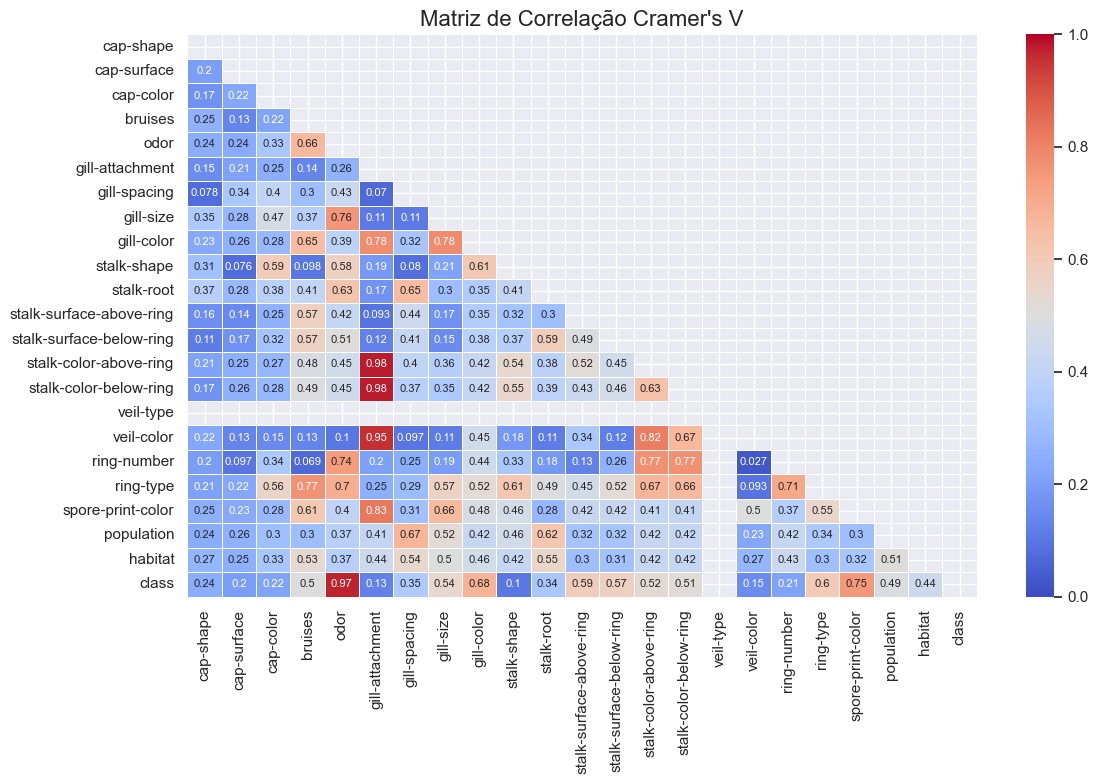

In [7]:
# Cria matriz de correlação usando Cramer's V
features = df.columns.tolist()
cramers_v_matrix = pd.DataFrame(index=features, columns=features)

for i in features:
    for j in features:
        if i == j:
            cramers_v_matrix.loc[i, j] = 1.0
        else:
            cramers_v_matrix.loc[i, j] = cramers_v(df[i], df[j])

# Converte para valores numéricos
cramers_v_matrix = cramers_v_matrix.astype(float)

# Visualização da matriz
plt.figure(figsize=(12, 8))
mask = np.triu(cramers_v_matrix)
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=mask, vmax=1, vmin=0, annot_kws={'fontsize': 8})
plt.title('Matriz de Correlação Cramer\'s V', fontsize=16)
plt.tight_layout()
plt.show()

In [8]:
# Variáveis mais correlacionadas com o target
class_correlations = cramers_v_matrix[['class']].sort_values(by='class', ascending=False)
display(class_correlations)

,class
class,1.000000
odor,0.970558
spore-print-color,0.752036
gill-color,0.679877
ring-type,0.602900
stalk-surface-above-ring,0.587666
stalk-surface-below-ring,0.574551
gill-size,0.539677
stalk-color-above-ring,0.523943
stalk-color-below-ring,0.513799


In [9]:
# Remoção da coluna 'stalk-root' devido a quantidade de valores nulos
df = df.drop(columns=['stalk-root'])

# Remoção de colunas com predominância de um único valor > 95%
df = df.drop(columns=df_cardinalidade[df_cardinalidade['valor_mais_frequente_%'] > 95]['feature'].values)

In [10]:
# Exportação da base tratada
df.to_csv(DADOS_TRATADOS, index=False)